# Task Definition

A binary segmentation mask (of the same height and width with the input image) should be created The segmentation mask should have a value of 1 at pixels where there is a building and 0 at other pixels.

The figure below showcases the input and output image expected. In the mask pixels that correspond to pixels in the input image are white and background is black.

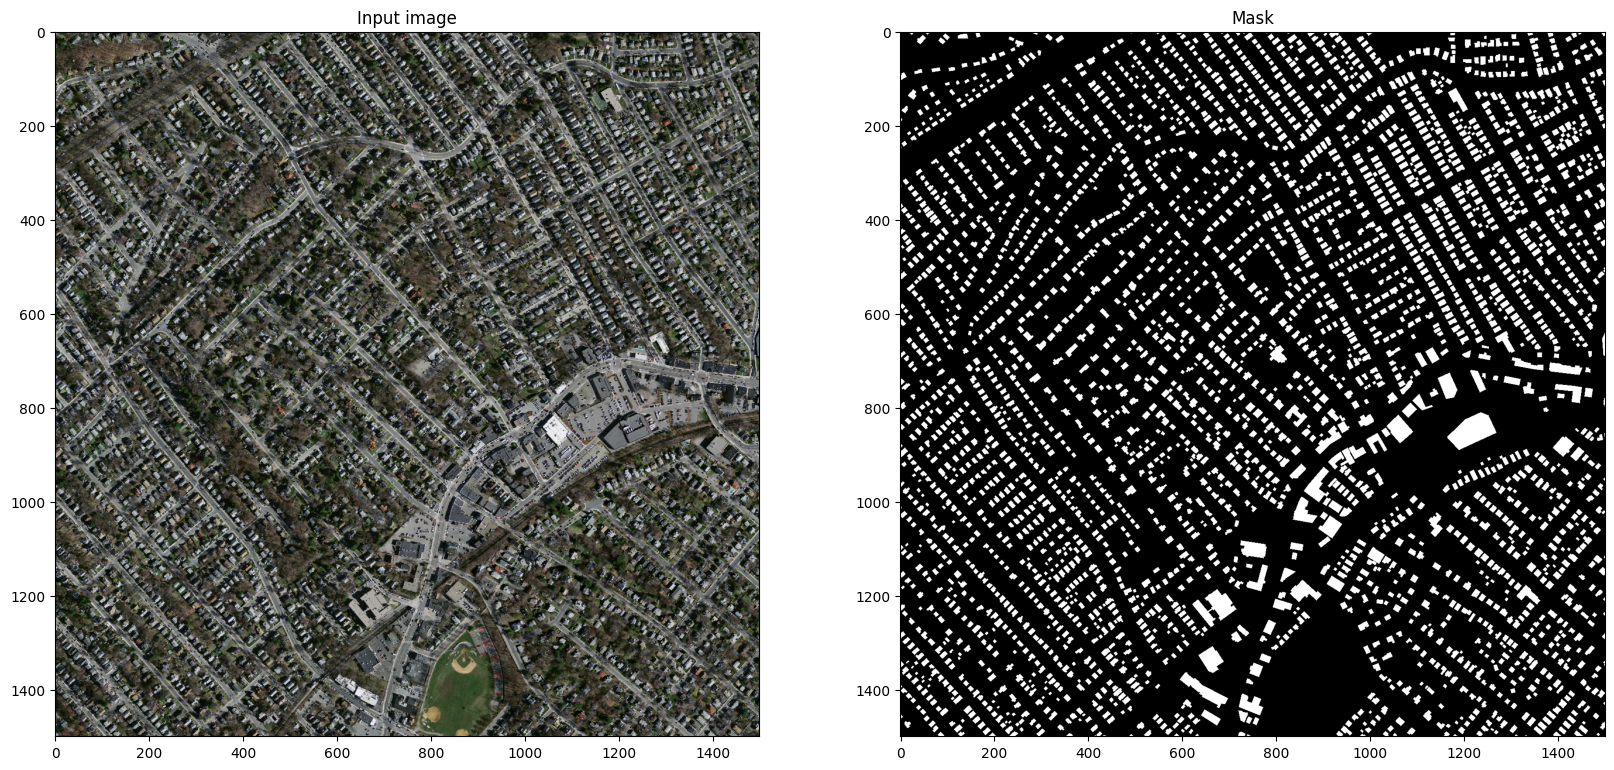

# Importing the Libraries

In [1]:
import numpy as np

# For image processing
from PIL import Image
import imageio

# For plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# For basic mathematical operations
import math

# For getting random samples from a list
import random

# Generally for listing directories and counting the number of files in folders
import os

# For image augmentation
from albumentations import Compose, HorizontalFlip, VerticalFlip, RandomRotate90, RandomBrightnessContrast, RandomCrop

# Base keras modules for deep learning
import keras
import keras.backend as K
from keras.models import Model
from keras.utils import Sequence

# Layers for CNNs
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Concatenate, BatchNormalization, Dropout, Conv2DTranspose

# Losses and metrics
from keras.losses import categorical_crossentropy, BinaryCrossentropy
from keras.metrics import BinaryAccuracy, Precision, BinaryIoU

# Callbacks
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint

# Optimzer
from keras.optimizers import Adam

In [2]:
# For reproducability
keras.utils.set_random_seed(42)

# Getting The data

The data used in this project is sourced from [Road and Building Detection Datasets](https://www.cs.toronto.edu/~vmnih/data/) with the following citation:

```
@phdthesis{MnihThesis,
    author = {Volodymyr Mnih},
    title = {Machine Learning for Aerial Image Labeling},
    school = {University of Toronto},
    year = {2013}
}

```

For the ease of use, relevant parts of this dataset was sourced from [kaggle.com](https://www.kaggle.com/datasets/balraj98/massachusetts-buildings-dataset)

**Upload kaggle.json before running following cell**

In [4]:
# DRAG & DROP kaggle.json to the file explorer before running this cell

# Create /root/.kaggle directory (if it does not exist already)
!mkdir -p /root/.kaggle/

# Test if kaggle.json is present
if "kaggle.json" not in os.listdir(".") and "kaggle.json" not in os.listdir("/root/.kaggle/"):
  raise Exception("Please upload kaggle.json to the current directory")

!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d balraj98/massachusetts-buildings-dataset

Dataset URL: https://www.kaggle.com/datasets/balraj98/massachusetts-buildings-dataset
License(s): other


In [5]:
# Unzip only tiff folder as it is the folder that will be used in the study
!unzip -qq massachusetts-buildings-dataset.zip tiff/*/*

# Exploratory Data Analysis and Preprocessing

In the dataset file in the kaggle, there is provided 2 seperate file formats for the same image. For instance, visuals of  tiff/train/22678915_15.tiff and png/train/22678915_15.tiff are the same.

Since png and tiff images correspond to the same visual, it was decided in this study to only use images of a single file format. Also, it is noticed that in the tiff folder, input images were of file format *.tiff and output masks were of the file format *.tif.

In this study *.tiff and *.tif file formats will be used.

In [6]:
train_path = "/content/tiff/train"
train_labels_path = "/content/tiff/train_labels"

val_path = "/content/tiff/val"
val_labels_path = "/content/tiff/val_labels"

test_path = "/content/tiff/test"
test_labels_path = "/content/tiff/test_labels"

The followind cell loads image files with *.tiff extension from a folder and returns two arrays (one for images and one for masks). The images are loaded from files at first to reduce I/O overhead while training in expense of increased memory usage.

In [7]:
def load_images(images_path, masks_path):
  """
    Loads images and corresponding labels from given paths. Returns a list of images and masks.

    ARGS:
      images_path: Path of the directory
      masks_path: Path of the directory

    RETURNS:
      two numpyt arrays for images and masks
   """
  img_paths = os.listdir(images_path)

  # return if there is no "*.tiff" file
  if any(".tiff" in filename for filename in img_paths) == False:
    print("There is not *.tiff files inside the folder")
    return

  imgs = []
  masks = []

  # Log info about path
  print(f"""Loading images... from {images_path} and masks from {masks_path}
        There are {len(os.listdir(images_path))} images and {len(os.listdir(masks_path))} masks""")

  for img_file in os.listdir(images_path):
    img = np.array(Image.open(images_path + "/"+img_file))
    mask = np.array(Image.open(masks_path + "/"+img_file.replace(".tiff", ".tif"))) # .tif instead of .tiff
    imgs.append(img)
    masks.append(mask)
  return np.array(imgs) / 255.0, np.array(masks) / 255.0

In [8]:
# Loads images and masks from folders

train_images, train_masks = load_images(train_path, train_labels_path)
val_images, val_masks = load_images(val_path, val_labels_path)
test_images, test_masks = load_images(test_path, test_labels_path)

print(f"Train images shape: {train_images.shape}")
print(f"Train masks shape: {train_masks.shape}")
print(f"Val images shape: {val_images.shape}")
print(f"Val masks shape: {val_masks.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test masks shape: {test_masks.shape}")

Loading images... from /content/tiff/train and masks from /content/tiff/train_labels
        There are 137 images and 137 masks
Loading images... from /content/tiff/val and masks from /content/tiff/val_labels
        There are 4 images and 4 masks
Loading images... from /content/tiff/test and masks from /content/tiff/test_labels
        There are 10 images and 10 masks
Train images shape: (137, 1500, 1500, 3)
Train masks shape: (137, 1500, 1500, 3)
Val images shape: (4, 1500, 1500, 3)
Val masks shape: (4, 1500, 1500, 3)
Test images shape: (10, 1500, 1500, 3)
Test masks shape: (10, 1500, 1500, 3)


In the following code cell, images were first sliced in slices of squares with a width of the defined patch_size. The training images were of shape (1500, 1500, 3), so there were slices generated for ranges of x-axis and y-axis of (0, 256), (256, 512),  (512, 768), (768, 1024) and (1024, 1280); as a result, a total of 5*5=25 patches were generated. The slices that remained outside those ranges were eliminated as they were too small to get a square patch of (256, 256).

In [9]:
def get_patches(img_array, mask_array,  patch_size= 256):
  '''
    Returns an array of patches of size (patch_size, patch_size) for an array of images

    ARGS:
      img: np array of minimum 4 dimensions (shape [batches, height, width, channels]) !!! single images should be expanded
      mask: mask image (np array)
      patch_size: the shape of each patch

    RETURNS:
      image patches (np array)
  '''
  img_height, img_width, _ = img_array.shape[-3:]

  # Get number of patches at +y (vertical, rows) and +x (horizontal, columns) directions
  ny, nx = img_height // patch_size, img_width // patch_size

  # define image and mask arays
  img_patches = []
  mask_patches = []
  for k in range(len(img_array)):
    for i in range(ny):
      for j in range(nx):
        img_ = img_array[k]
        mask_ = mask_array[k]

        img_ = img_[i * patch_size : (i+1) * patch_size,j * patch_size : (j+1) * patch_size]
        mask_ = mask_[i * patch_size : (i+1) * patch_size,j * patch_size : (j+1) * patch_size]
        img_patches.append(img_)
        mask_patches.append(mask_)
  np_imgs = np.array(img_patches).reshape((-1, patch_size, patch_size, 3))
  np_masks = np.array(mask_patches).reshape((-1, patch_size, patch_size, 3))

  return np_imgs, np_masks

In [10]:
# Turn images into (256, 256, 3) patches

train_img_patches, train_mask_patches = get_patches(train_images, train_masks)
val_img_patches, val_mask_patches = get_patches(val_images, val_masks)
test_img_patches, test_mask_patches = get_patches(test_images, test_masks)

Later, it was noticed that some images from the dataset had random crops. However, in this study, it was undesirable to have random crops in the input image itself.
Therefore, parts of image that had pixels of pure white (rgb --> 255, 255, 255) in more than 1% were eliminated from the data.

An image with a big crop is shown below:

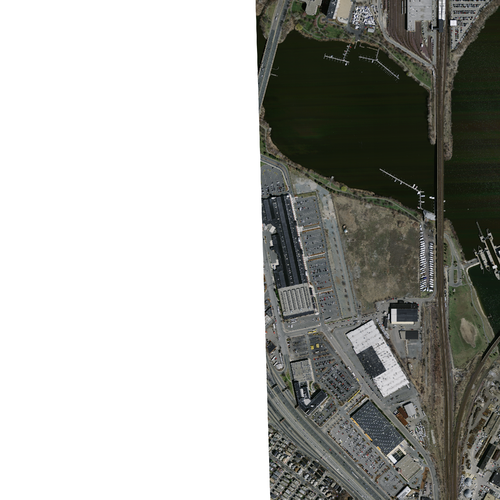

In [11]:
train_img_patches.shape

(3425, 256, 256, 3)

In [12]:
def remove_white_pixels(img_array, mask_array, tolerance= .05):
  """
    Removes images when ratio of white pixels is above the tolerance.

    Args:
      img_array: np array of shape (height, width, channels).
      mask_array: np array of shape (height, width, channels).
      tolerance: float between 0 and 1.

    Returns:
      img_array: np array of shape (height, width, channels).
      mask_array: np array of shape (height, width, channels).
  """
  img_patches = []
  mask_patches = []
  n = 0
  for i in range(img_array.shape[0]):
    img_ = img_array[i]
    mask_ = mask_array[i]

    number_of_white_pixels = np.sum(np.any(img_ == [1, 1, 1], axis=-1))
    white_ratio = number_of_white_pixels / (img_.shape[0] * img_.shape[1])

    if white_ratio < tolerance:
      img_patches.append(img_)
      mask_patches.append(mask_)
    else:
      n += 1
  print(n, " patches skipped")
  return np.array(img_patches), np.array(mask_patches)


In [13]:
train_img_patches, train_mask_patches = remove_white_pixels(train_img_patches, train_mask_patches)
val_img_patches, val_mask_patches = remove_white_pixels(val_img_patches, val_mask_patches)
test_img_patches, test_mask_patches = remove_white_pixels(test_img_patches, test_mask_patches)

355  patches skipped
0  patches skipped
0  patches skipped


Since the problem is to semanticaly segment images into buildings or not-buildings. The problem is **binary image segmenmtation**. Therefore, the RGB color of masks is not needed. For that reason, masks have been converted to grayscale by taking the mean of all 3 color channels for each pixel.

In [14]:
def grayscale_masks(masks):
  """
    Converts mask to grayscale.

    ARGS:
      masks: array of masks

    RETURNS:
      grayscale masks
  """
  return np.mean(masks, axis=-1, keepdims=True)
train_mask_patches = grayscale_masks(train_mask_patches)
val_mask_patches = grayscale_masks(val_mask_patches)
test_mask_patches = grayscale_masks(test_mask_patches)

In [15]:
# As mask patches are converted into grayscale, they are now consisting of a single channel.
train_mask_patches.shape, val_mask_patches.shape, test_mask_patches.shape

((3070, 256, 256, 1), (100, 256, 256, 1), (250, 256, 256, 1))

In [16]:
# outputs should be binary (0 or 1) representing existence of building on a specific pixel.
np.unique(train_mask_patches[5])

array([0., 1.])

## plot sample images from patches array

Below cell plots sample images from training patches and overlays the expected mask for buildings in blue to check whether masks in the dataset are correct.

The masks used in the figure below are ground-truth.

The images are titled with building ratio inside the image. The building ratio is found by counting pixels with a mask value of 1 and then dividing it to the total number of pixels in the image.

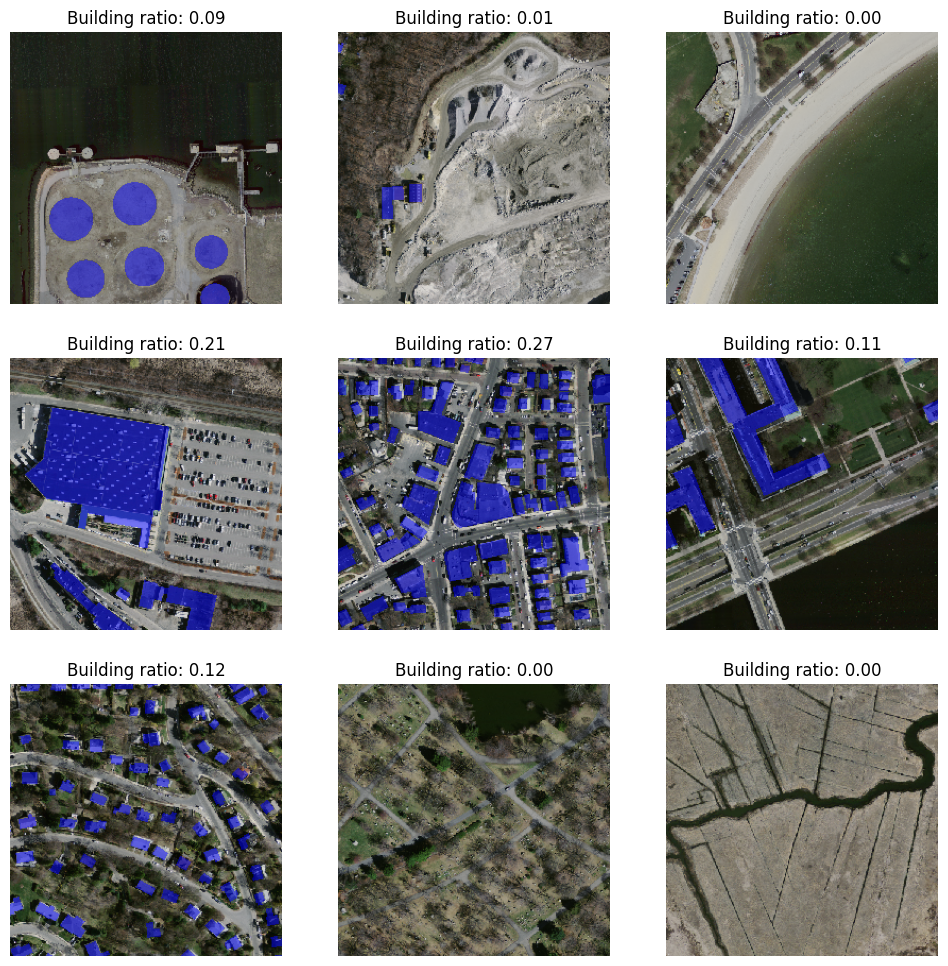

In [17]:
# plot images from train_images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
cmap = mcolors.ListedColormap(['none', 'blue'])

for i in range(9):
  # x = random.choice(train_images)
  n = np.random.randint(0, len(train_img_patches))
  # print(n) # uncomment if needed to find the image inside the array

  x = train_img_patches[n]
  y = train_mask_patches[n]

  building_ratio = np.sum(y == 1) / (256 * 256)

  axes[i//3, i%3].imshow(x)
  axes[i//3, i%3].imshow(y, cmap=cmap, alpha=.5)
  axes[i//3, i%3].axis('off')
  axes[i//3, i%3].set_title("Building ratio: {:.2f}".format(building_ratio))
plt.show()

## Data Augmentation

Data augmentations are used to create data that is not tied to the tight features in the input dataset. Adding random flips and rotations help the model generalize better and predict more correctly.

In [18]:
augmentations = Compose([
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            RandomRotate90(p=0.5),
        ])

## Implementing Data Generator


In [19]:
train_img_patches.shape, train_mask_patches.shape

((3070, 256, 256, 3), (3070, 256, 256, 1))

As seen from above cell, there are 3070 distinct patches in the training data alone. Loading all these patches would be costly in a performance sense.

For generating batches of data to each batch defined 3 cells above, a data genearor class is defined.

Also the dataGenerator class defined below applies augmentations defined in an argument to the data. Therefore, flexibility to apply or not apply augmentations is offered.

In [20]:
class DataGenerator(Sequence):
  def __init__(self, img_array, mask_array, batch_size=32, augmentations = None, shuffle = True):
        """
          img_array and mask_array must be ordered in the same manner.
        """
        self.img_array = img_array
        self.mask_array = mask_array
        self.batch_size = batch_size
        self.augmentations = augmentations
        self.shuffle = shuffle
  def __len__(self):
    return int(len(self.img_array) / self.batch_size)

  def __getitem__(self, index):
    start = index * self.batch_size
    end = (index + 1) * self.batch_size

    # Get a batch of images and masks
    X = self.img_array[start:end]
    y = self.mask_array[start:end]

    X_copy = np.zeros_like(X)
    y_copy = np.zeros_like(y)

    for i in range(self.batch_size):
      X_copy[i], y_copy[i] = self.data_generation(X[i], y[i])

    return X_copy, y_copy

  def data_generation(self, X, y):
    X_copy = X.copy()
    y_copy = y.copy()

    if self.augmentations is not None:
      transformed = self.augmentations(image  = X, mask = y)
      X_copy = transformed['image']
      y_copy = transformed['mask']
    return X_copy, y_copy
  def on_epoch_end(self):
    if not self.shuffle:
      return
    if random.random() > .1:
      return
    # shuffle the dataset with a 10% chance
    print("\n Shuffling...\n")
    num_samples = len(self.img_array)
    shuffled_indices = np.arange(num_samples)

    np.random.shuffle(shuffled_indices)

    self.img_array = self.img_array[shuffled_indices]
    self.mask_array = self.mask_array[shuffled_indices]

In [21]:
trainGen = DataGenerator(train_img_patches, train_mask_patches, batch_size=32, augmentations=augmentations)
valGen = DataGenerator(val_img_patches, val_mask_patches)
testGen = DataGenerator(test_img_patches, test_mask_patches)

In [22]:
print("Shape of a training batch: ",trainGen[0][0].shape, trainGen[0][1].shape)
print("Shape of a validation batch: ",valGen[0][0].shape, valGen[0][1].shape)
print("Shape of a test batch: ",testGen[0][0].shape, testGen[0][1].shape)

Shape of a training batch:  (32, 256, 256, 3) (32, 256, 256, 1)
Shape of a validation batch:  (32, 256, 256, 3) (32, 256, 256, 1)
Shape of a test batch:  (32, 256, 256, 3) (32, 256, 256, 1)


## Sample Images from data generator

Below cell, gets a random image and a mask from a random batch and plots them both side-by-side in order to ensure that the image and mask are tied with each other.

(32, 256, 256, 3) (32, 256, 256, 1)


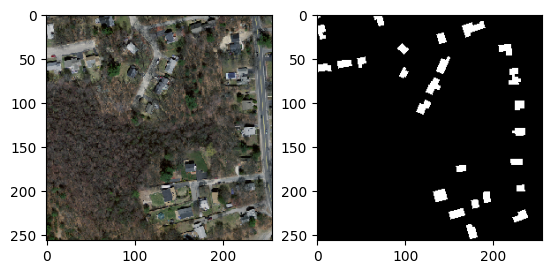

In [23]:
# For Train

randomImageBatch, randomMaskBatch = random.choice(trainGen)
print(randomImageBatch.shape, randomMaskBatch.shape)
k = random.randint(0, 15)

fig, axes = plt.subplots(1, 2)

axes[0].imshow(randomImageBatch[k])
axes[1].imshow(randomMaskBatch[k], cmap="gray")

# Building a model

A U-Net model will be used for the image segmentation task. It consists of encoder (a.k.a. contracting path) and decoder (a.k.a. expanding path) paths that are connected by skip connections and a bottleneck.

In the encoder path, 4 layers of double convolution (2 convolution back to back) with increased number of filters at each layer are present. The image is pooled in each layer, so that the image gets increasingly down-sampled at each layer. The series of downscaling allows imgaes features to be concantrated in smaller areas, thus making information density per pixel larger. This concantration of features in small area allow the subsequent layers to capture higher level details like shape and alignment of objects.

In the decoder path, 4 layers of double up-convolution blocks (with decreasing number of filters) are used to create the segmented output image out of down-sampled feature maps.

To compansate the loss of information through encoder path, skip connections between layers of encoder path and layers of decoder path are used. In the code, skip connections are modeled by Concatenate() layers as features from encoding path are concatenated directly to the decoding layer features.

In [24]:
def doubleConv(input, filters, dropout):
  x = Conv2D(filters, 3, activation='relu', padding='same')(input)
  x = Dropout(dropout)(x)
  x = Conv2D(filters, 3, activation='relu', padding='same')(x)
  return x

def doubleUpConv(input, filters):
  x = Conv2DTranspose(filters, 3, activation='relu', padding='same')(input)
  x = Conv2DTranspose(filters, 3, strides = 2, activation='relu', padding='same')(x)
  return x

In [25]:
def build_unet(inputs, dropout):
    '''Encoder'''
    x_skip_1 = doubleConv(inputs, 32, dropout)
    x_temp = MaxPooling2D(2)(x_skip_1)

    x_skip_2 = doubleConv(x_temp, 64, dropout)
    x_temp = MaxPooling2D(2)(x_skip_2)

    x_skip_3 = doubleConv(x_temp, 128, dropout)
    x_temp = MaxPooling2D(2)(x_skip_3)

    x_skip_4 = doubleConv(x_temp, 256, dropout)
    x_temp = MaxPooling2D(2)(x_skip_4)

    '''Bottleneck'''

    x_temp = doubleConv(x_temp, 512, dropout)

    '''Decoder'''
    x_temp = doubleUpConv(x_temp, 256)
    x_temp = Concatenate()([x_temp, x_skip_4])

    x_temp = doubleUpConv(x_temp, 128)
    x_temp = Concatenate()([x_temp, x_skip_3])

    x_temp = doubleUpConv(x_temp, 64)
    x_temp = Concatenate()([x_temp, x_skip_2])

    x_temp = doubleUpConv(x_temp, 32)
    x_temp = Concatenate()([x_temp, x_skip_1])

    '''Output'''

    x_temp = doubleConv(x_temp, 32, 0)
    x_out = Conv2D(1, 1, activation='sigmoid', padding='same')(x_temp)

    return Model(inputs = inputs, outputs = x_out)

In [26]:
x_in = Input(shape=(256, 256, 3))

model = build_unet(x_in, .1)
model.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics=[BinaryAccuracy(), Precision(), BinaryIoU()])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ dropout_3[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 7,478,081 (28.53 MB)

 Trainable params: 7,478,081 (28.53 MB)

 Non-trainable params: 0 (0.00 B)

## Setting some callbacks

Learning rate is the rate of change of network weights to the loss. A high learning rate will make the model faster to train but susceptible to overshoots. Genrally setting a high learning rate and gradually decreasing it after the model stops improving is a good idea. Therefore, ReduceLrOnPlateau callback will be used in this model which tracks validation loss and reduces learning rate when validation loss doesn't get lower for 2 epochs.

Also, for later documentation; a training.log will be generated.

In [29]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1),
    CSVLogger('training.log', separator=',', append=False),
    ModelCheckpoint(filepath = 'checkpoints/model_.{epoch:02d}-{val_loss:.6f}.weights.h5', verbose=1, save_best_only=True, save_weights_only = True)
]

## Training

In [30]:
history = model.fit(trainGen, validation_data=valGen, epochs=25, callbacks=[callbacks])

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - binary_accuracy: 0.8418 - binary_io_u: 0.4383 - loss: 0.4458 - precision: 0.1889
Epoch 1: val_loss improved from inf to 0.26566, saving model to checkpoints/model_.01-0.265661.weights.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 79s 365ms/step - binary_accuracy: 0.8421 - binary_io_u: 0.4383 - loss: 0.4451 - precision: 0.1889 - val_binary_accuracy: 0.8905 - val_binary_io_u: 0.4453 - val_loss: 0.2657 - val_precision: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - binary_accuracy: 0.8693 - binary_io_u: 0.4537 - loss: 0.3114 - precision: 0.5537
 Shuffling...


 Shuffling...


Epoch 2: val_loss improved from 0.26566 to 0.25503, saving model to checkpoints/model_.02-0.255025.weights.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 28s 296ms/step - binary_accuracy: 0.8693 - binary_io_u: 0.4539 - loss: 0.3113 - precision: 0.5546 - val_binary_accuracy: 0.9089 - val_binary_io_u: 0.5981 - val_loss: 0.2550 - val_precision: 0.6633 - learning_rate: 

# Testing the model with sample images

m:  27
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Unique values:  [5.8671316e-07 7.0355571e-07 7.7192919e-07 ... 9.9752945e-01 9.9782228e-01
 9.9818194e-01]
(1, 256, 256, 1)
Uniques:  [0 1]


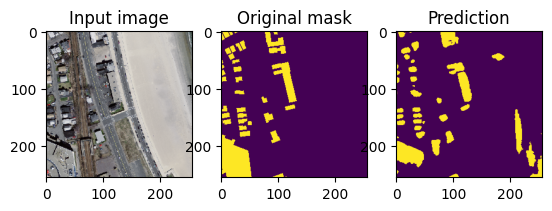

In [31]:
m = random.randint(0, 31)
batch_number = 3
print("m: ", m)
pred_test = model.predict(np.expand_dims(testGen[batch_number][0][m], axis=0))
print("Unique values: ",np.unique(pred_test))

# Since the output of sigmoid activation is between 0 and 1 --> we can threshold it with .5
threshold = .5
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)
print("Uniques: ", np.unique(pred_test))

fig, axes = plt.subplots(1, 3)

axes[0].set_title('Input image')
axes[0].imshow(testGen[batch_number][0][m])

mask_ = testGen[batch_number][1][m]
pred_ = pred_test[:, :]

axes[1].set_title('Original mask')
axes[1].imshow(mask_)

axes[2].set_title('Prediction')
axes[2].imshow(pred_[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


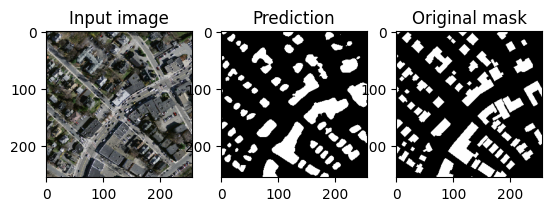

In [32]:
# This cell is to test the model on raw image

# model expects values to be between 0 and 1
sample_img = np.array(Image.open("/content/tiff/test/22828930_15.tiff")) / 256.0
sample_mask = np.array(Image.open("/content/tiff/test_labels/22828930_15.tif")) / 256.0

nn = 3

xxx = np.expand_dims(sample_img[nn*256:(nn+1)*256, nn*256:(nn+1)*256], axis = 0)
yyy = sample_mask[nn*256:(nn+1)*256, nn*256:(nn+1)*256]
pred = model.predict(xxx)
pred = (pred > .5).astype(np.uint8)

fig, axes = plt.subplots(1, 3)
axes[0].set_title('Input image')
axes[0].imshow(xxx[0])
axes[1].set_title('Prediction')
axes[1].imshow(pred[0], cmap="gray")
axes[2].set_title('Original mask')
axes[2].imshow(yyy)

# Implementing image division and concatenation for predicting input of any size

Since the model works only on (256, 256) input images and objects (buildings) inside the images are of little size, sliding window approach will be used in this work.

In [33]:
def calculate_padding(image, patch_size=256):
  """
    Calculates required padding amounts

    ARGS:
      image: Image to be padded (height, width, channels)
      patch_size: Stride of the patches

    RETURNS:
      padding: Padding amounts (top, bottom, left, right)
  """

  height, width = image.shape[-3:-1]

  # Calculate Desired shape
  xx = (width // patch_size +1) * patch_size
  yy = (height // patch_size +1) * patch_size

  # Calculate padding amounts
  x_pad = xx - width
  y_pad = yy - height

  x0 = x_pad // 2
  x1 = x_pad - x0
  y0 = y_pad // 2
  y1 = y_pad - y0

  return (y0, y1, x0, x1)

In [34]:
def apply_padding(image, patch_size=256):
  """
    Adds padding to the image to make patches of equal size that covers the entire image

    ARGS:
      image: Image to be padded
      patch_size: Stride of the patches

    RETURNS:
      padded_image: Padded image
  """
  width, height = image.shape[:2]
  pad_y0, pad_y1, pad_x0, pad_x1 = calculate_padding(image, patch_size)

  return np.pad(image, ((pad_y0, pad_y1), (pad_x0, pad_x1), (0, 0)), mode='constant')

In [35]:
def predict(model, img, threshold=0.5, patch_size=256):
  """
    model: a keras model
    img: a np array representing the image (expects float dtype and values between 0 and 1)
  """
  padded = apply_padding(img, patch_size)

  number_of_rows, number_of_columns = math.ceil(img.shape[0] /patch_size), math.ceil(img.shape[1] /patch_size)
  # fig, axes = plt.subplots(number_of_rows, number_of_columns, figsize=(20, 20))
  prediction = np.zeros((number_of_rows * patch_size, number_of_columns * patch_size, 1), dtype="float32")

  for i in range(0, number_of_rows):
    for j in range(0, number_of_columns):
      # Convert to float
      slc = padded[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] / 256.0
      pred = model.predict(np.expand_dims(slc, axis = 0), verbose = 0)
      # axes[i][j].imshow(pred[0])
      prediction[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = pred[0]

  # Threshold the results
  prediction = (prediction > threshold).astype(np.uint8)

  # Reverse padding
  y0, y1, x0, x1 = calculate_padding(img, patch_size)
  preds = prediction[y0:-y1, x0:-x1]
  return preds


Text(0.5, 1.0, 'Prediction')

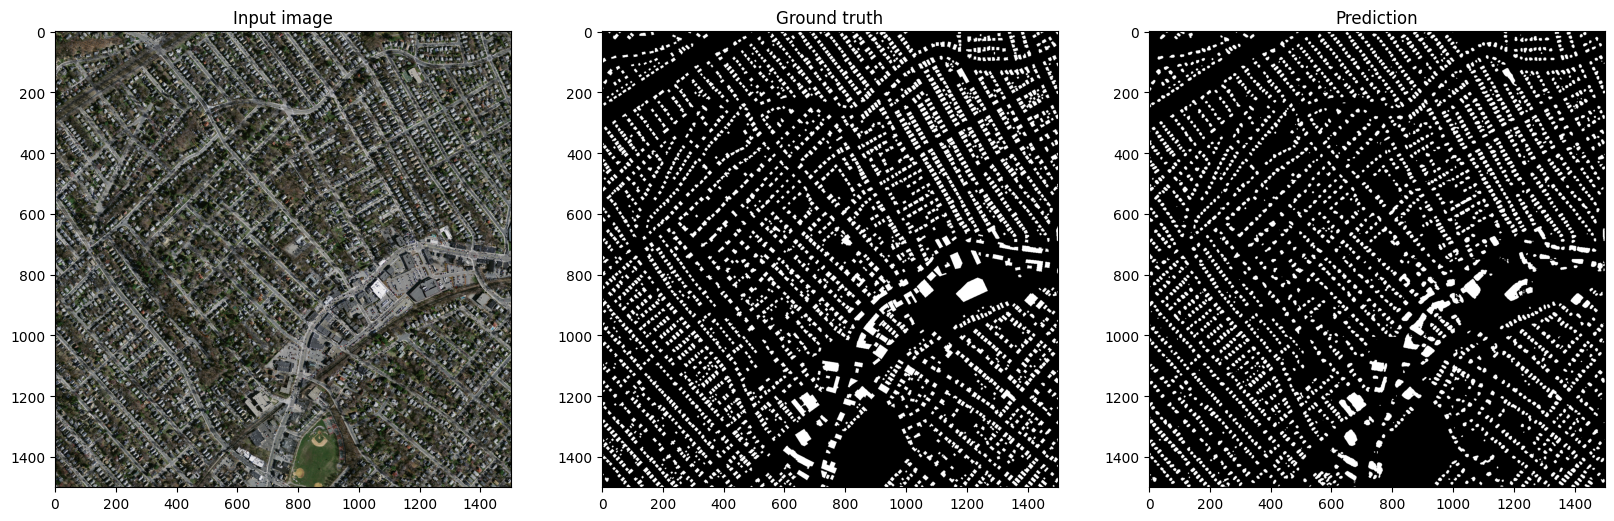

In [36]:
sample_img = np.array(Image.open("/content/tiff/test/22828930_15.tiff"))
segmented = predict(model, sample_img ,threshold=0.5)

fig, axes = plt.subplots(1, 3, figsize=(20, 20))
axes[0].imshow(sample_img)
axes[0].set_title('Input image')
axes[1].imshow(Image.open("/content/tiff/test_labels/22828930_15.tif"))
axes[1].set_title('Ground truth')
axes[2].imshow(segmented, cmap="gray")
axes[2].set_title('Prediction')

# Evaluation

Below cell creates two plots for the binary cross entropy (BCE) loss and intersection-over-union (IoU) of model at each epoch for both training and validation data.

As seen from the plots, training and validation losses do move together to the lower values. As they both get lower progressively, it can be claimed that the model has not suffered overfitting due to the model memorizing training data.

Also, it is noticed that intersection over union (IoU) goes fast till it reaches values in the range of 0.70s.
This signifies that either the model structure, training method or data pre-processing needs to further improve and get IoU values over 80%-90%.

For this work, the obtained results were deemed sufficient.

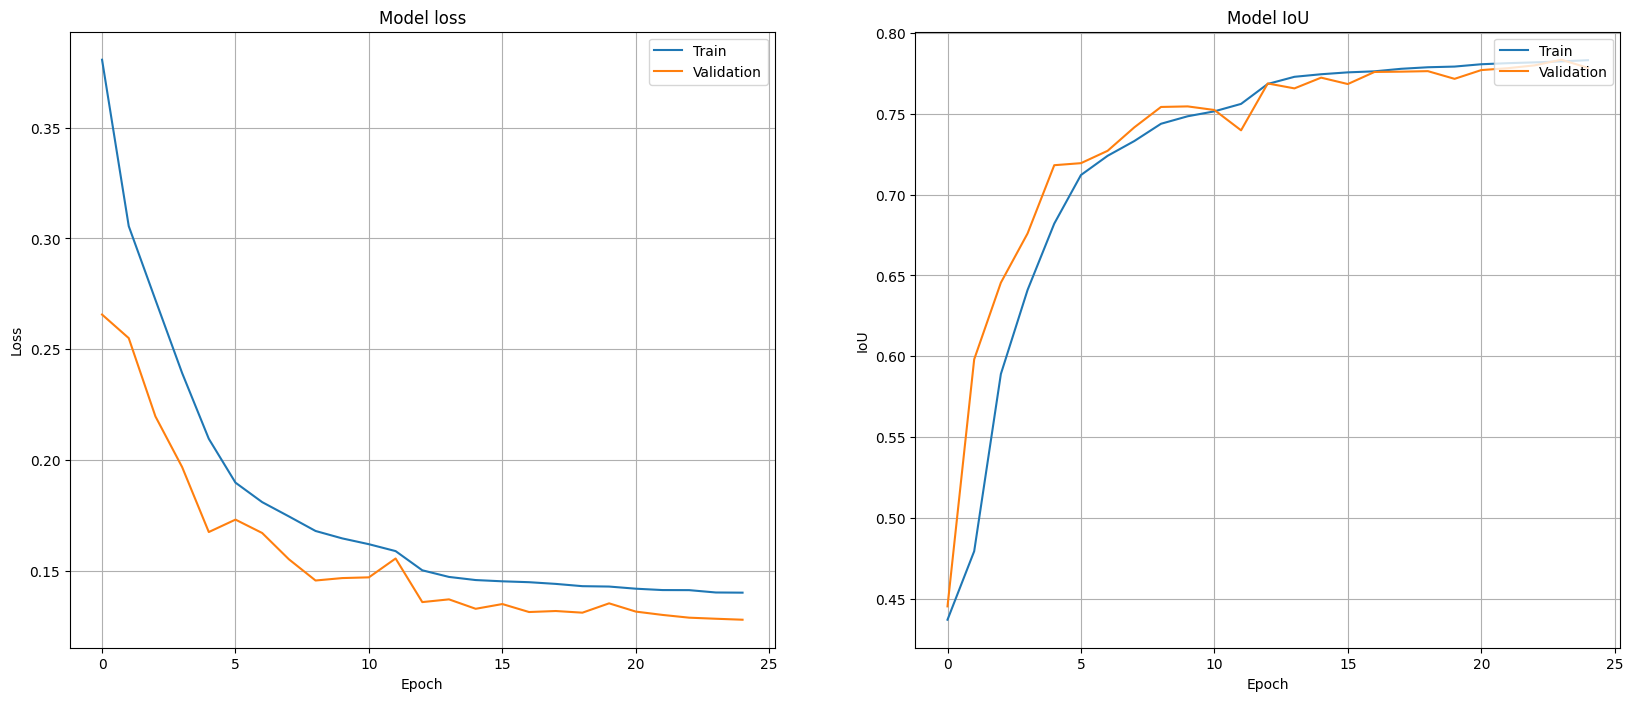

In [37]:
metrics_ = history.history

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].plot(metrics_['loss'])
axes[0].plot(metrics_['val_loss'])
axes[0].set_title('Model loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper right')
axes[0].grid()

axes[1].plot(metrics_['binary_io_u'])
axes[1].plot(metrics_['val_binary_io_u'])
axes[1].set_title('Model IoU')
axes[1].set_ylabel('IoU')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper right')
axes[1].grid()

# Conclusion

A unet model capable of performing building footprint segmentation on aerieal imagery with over 70% intersection-over-iou has been created.